# Stochastic Weight Averaging - Gaussian (SWAG)

## Theoretic Foundation

SWAG is an approximate Bayesian method and uses a low-rank Gaussian distribution as an approximation to the posterior over model parameters. The quality of approximation to the posterior over model parameters is based on using a high SGD learning rate that periodically stores weight parameters in the last few epochs of training [Maddox, 2019](https://arxiv.org/abs/1902.02476). SWAG is based on Stochastic Weight Averaging (SWA), as proposed in [Izmailov, 2018](https://arxiv.org/pdf/1803.05407.pdf%20%20https://github.com/timgaripov/swa). For SWA the weights are obtained by minimising the MSE loss with a variant of stochastic gradient descent. After, a number of burn-in epochs, $\tilde{t} = T-m$, the last $m$ weights are stored and averaged to obtain an approximation to the posterior, by

$$
    \theta_{SWA} = \frac{1}{m}\sum_{t=\tilde{t}}^T \theta_t.
$$

For SWAG we use the implementation as proposed by [Maddox, 2019](https://arxiv.org/abs/1902.02476). Here the posterior is approximated by a Gaussian distribution with the SWA mean and a covariance matrix over the stochastic parameters that consists of a low rank matrix plus a diagonal, 

$$
    p(\theta |D) \approxeq \mathcal{N}\left(\theta_{SWA}, \frac{1}{2}(\Sigma_{diag}+\Sigma_{low-rank})\right).
$$

The diagonal part of the covariance is given by

$$
    \Sigma_{diag} = \text{diag}(\bar{\theta^2} - \theta_{SWA}^2)
$$

where,

$$
    \bar{\theta^2} = \frac{1}{m}\sum_{t=\tilde{t}}^T \theta_t^2.
$$

The low rank part of the covariance is given by

$$
    \Sigma_{low-rank} =  \frac{1}{m}\sum_{t=\tilde{t}}^T (\theta_t - \bar{\theta}_t) (\theta_t - \bar{\theta}_t)^T,
$$

where $\bar{\theta}_t$ is the running estimate of the mean of the parameters from the first $t$ epochs or also samples. In order to approximate the mean prediction, we again resort to sampling from the posterior. With $\theta_s \sim p(\theta|D)$ for $s \in \{1, ...,S\}$, the mean prediction is given by

$$
    \hat{y}(x^{\star}) = \frac{1}{S} \sum_{s=1}^S f_{\theta_s}(x^{\star}),
$$

and obtain the predictive uncertainty by

$$
    \sigma(x^{\star}) = \sqrt{\frac{1}{S} \sum_{s=1}^S f_{\theta_s}(x^{\star})^2 - \hat{y}(x^{\star})^2}.
$$

For the subnet strategy, we include selecting the parameters to be stochastic by module names. 


## Imports

In [26]:
import tempfile
from functools import partial
import os

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.datamodules import ToyHeteroscedasticDatamodule
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import NLL, MVERegression, SWAGRegression
from lightning_uq_box.viz_utils import (
    plot_calibration_uq_toolbox,
    plot_predictions_regression,
    plot_toy_regression_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
seed_everything(0)  # seed everything for reproducibility

Seed set to 0


0

We define a temporary directory to look at some training metrics and results.

In [3]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

To demonstrate the method, we will make use of a Toy Regression Example that is defined as a [Lightning Datamodule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html). While this might seem like overkill for a small toy problem, we think it is more helpful how the individual pieces of the library fit together so you can train models on more complex tasks.

In [4]:
dm = ToyHeteroscedasticDatamodule()

X_train, y_train, train_loader, X_test, y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)

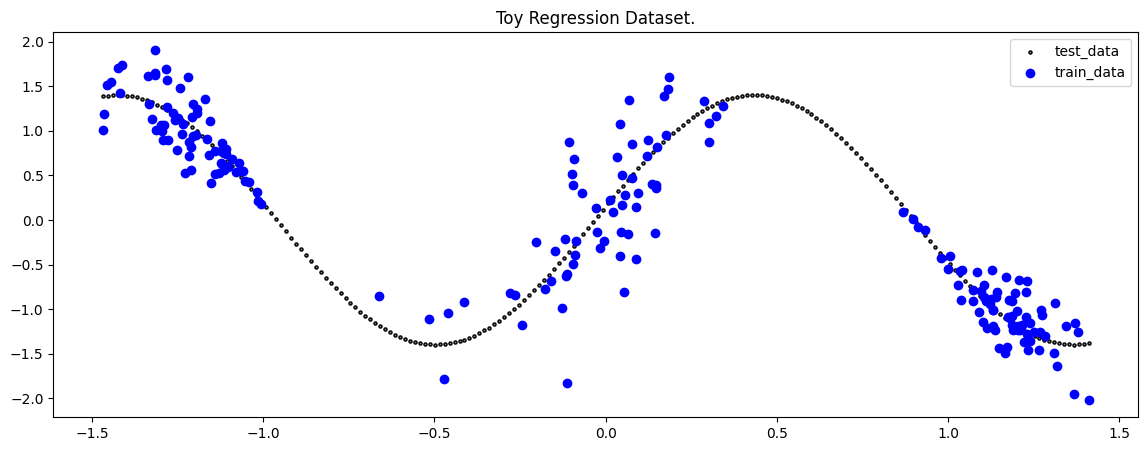

In [5]:
plot_toy_regression_data(X_train, y_train, X_test, y_test)

## Model

For our Toy Regression problem, we will use a simple Multi-layer Perceptron (MLP) that you can configure to your needs. For the documentation of the MLP see [here](https://readthedocs.io/en/stable/api/models.html#MLP). We define a model with two outputs to train with the Negative Log Likelihood.

In [6]:
network = MLP(n_inputs=1, n_hidden=[50, 50, 50], n_outputs=2, activation_fn=nn.Tanh())
network

MLP(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Tanh()
    (8): Dropout(p=0.0, inplace=False)
    (9): Linear(in_features=50, out_features=2, bias=True)
  )
)

With an underlying neural network, we can now use our desired UQ-Method as a sort of wrapper. All UQ-Methods are implemented as [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html) that allow us to concisely organize the code and remove as much boilerplate code as possible. In the case of SWAG, the method is implemented as a sort of "post-processin" step, where you first train a model with a MAP estimate and subsequently apply SWAG to capture epistemic uncertainty over the neural network weights. Hence, we will first fit a deterministic model, in this case one that outputs the parameters of a Gaussian Distribution and train with the Negative Log Likelihood.

In [8]:
deterministic_model = MVERegression(
    network, burnin_epochs=50, optimizer=partial(torch.optim.Adam, lr=1e-3)
)

## Trainer

Now that we have a LightningDataModule and a UQ-Method as a LightningModule, we can conduct training with a [Lightning Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html). It has tons of options to make your life easier, so we encourage you to check the documentation.

In [9]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=250,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training our model is now easy:

In [10]:
trainer.fit(deterministic_model, dm)

Missing logger folder: /tmp/tmpjd_5jq7p/lightning_logs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MLP              | 5.3 K 
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | loss_fn       | NLL              | 0     
---------------------------------------------------
5.3 K     Trainable params
0         Non-trainable params
5.3 K     Total params
0.021     Total estimated model params size (MB)
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.

## Training Metrics

To get some insights into how the training went of our underlying deterministic model, we can use the utility function to plot the training loss and RMSE metric.

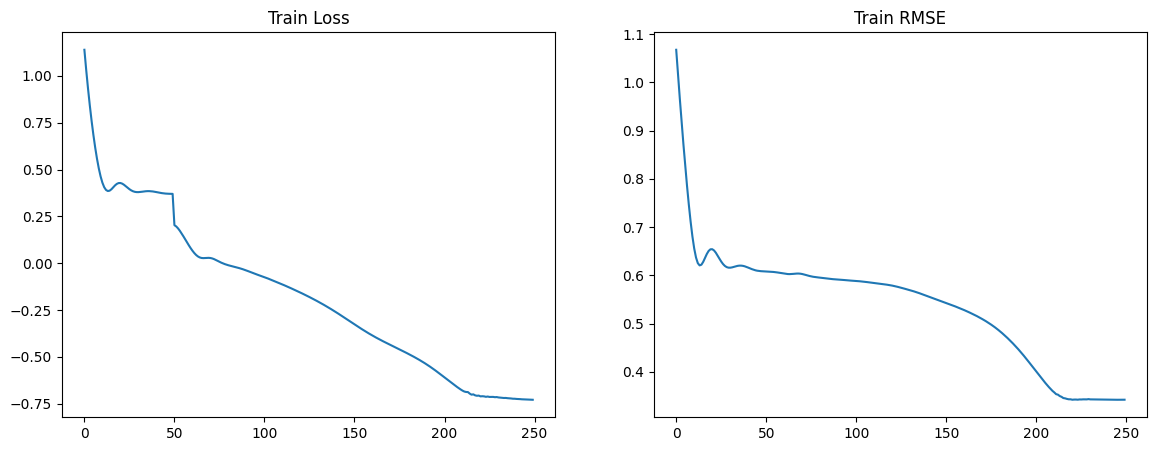

In [13]:
fig = plot_training_metrics(os.path.join(my_temp_dir, "lightning_logs"), "RMSE")

We can also make predictions with the underlying model.

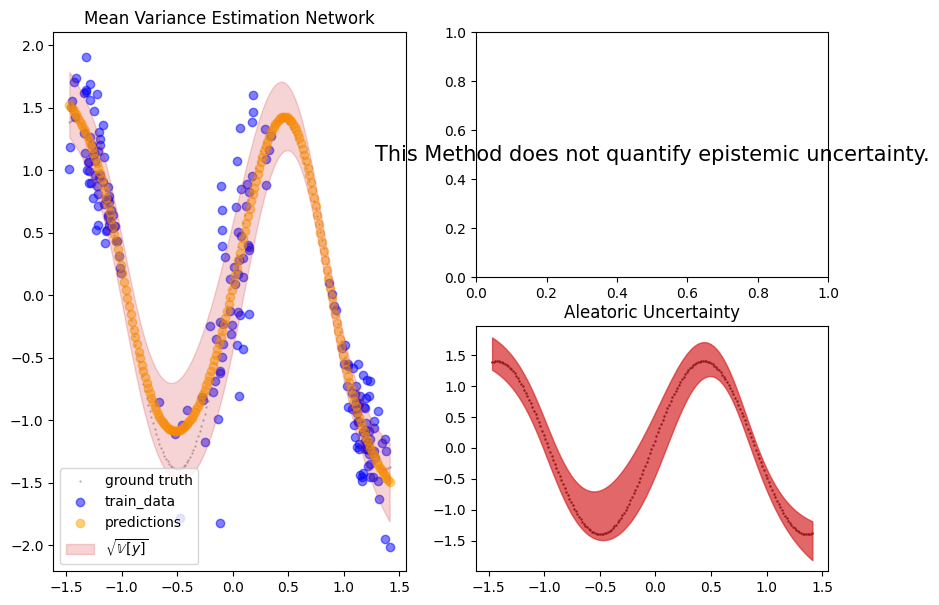

In [14]:
deterministic_preds = deterministic_model.predict_step(X_test)
fig = plot_predictions_regression(
    X_train,
    y_train,
    X_test,
    y_test,
    deterministic_preds["pred"],
    deterministic_preds["pred_uct"],
    aleatoric=deterministic_preds["aleatoric_uct"],
    title="Mean Variance Estimation Network",
)

## Apply SWAG

We now have a deterministic model that can make predictions, however, we do not have any uncertainty around the network weights. SWAG is a Bayesian Approximation method to capture this uncertainty, and we will now apply it to obtain epistemic uncertainty.

In [29]:
swag_model = SWAGRegression(
    deterministic_model.model,
    max_swag_snapshots=30,
    snapshot_freq=1,
    num_mc_samples=50,
    swag_lr=1e-3,
    loss_fn=NLL(),
)
swag_trainer = Trainer(
    max_epochs=20,  # number of epochs to fit swag
    log_every_n_steps=1,
    enable_progress_bar=False,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Prediction

For prediction we can either rely on the `trainer.test()` method or manually conduct a `predict_step()`. Using the trainer will save the predictions and some metrics to a CSV file, while the manual `predict_step()` with a single input tensor will generate a dictionary that holds the mean prediction as well as some other quantities of interest, for example the predicted standard deviation or quantile. The SWAG wrapper module will conduct the SWAG fitting procedure automatically before making the first prediction and will use it for any subsequent call to sample network weights for the desired number of Monte Carlo samples.

In [30]:
swag_trainer.fit(swag_model, datamodule=dm)
preds = swag_model.predict_step(X_test)


  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MLP              | 5.3 K 
1 | optimizer     | NLL              | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
5.3 K     Trainable params
0         Non-trainable params
5.3 K     Total params
0.021     Total estimated model params size (MB)


/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=20` reached.


## Evaluate Predictions

In [31]:
for key, val in preds.items():
    print(key, val.shape)

pred torch.Size([200, 1])
pred_uct torch.Size([200])
epistemic_uct torch.Size([200])
aleatoric_uct torch.Size([200])


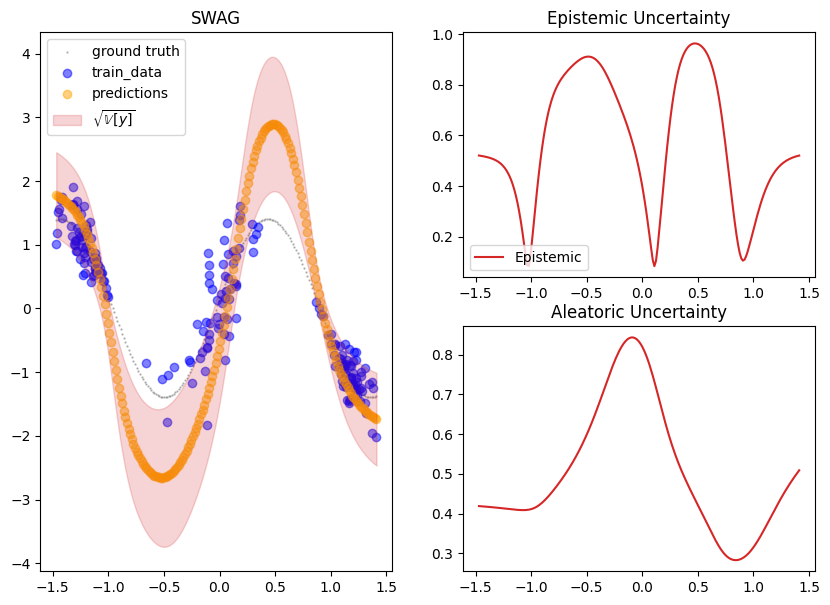

In [33]:
fig = plot_predictions_regression(
    X_train,
    y_train,
    X_test,
    y_test,
    preds["pred"],
    preds["pred_uct"],
    epistemic=preds["epistemic_uct"],
    aleatoric=preds["aleatoric_uct"],
    title="SWAG",
    show_bands=False,
)

In the above plot we can observe, that we also now nave an estimate of the epistemic uncertainy with the SWAG method.

For some additional metrics relevant to UQ, we can use the great [uncertainty-toolbox](https://uncertainty-toolbox.github.io/) that gives us some insight into the calibration of our prediction. For a discussion of why this is important, see ...

<Figure size 1400x500 with 0 Axes>

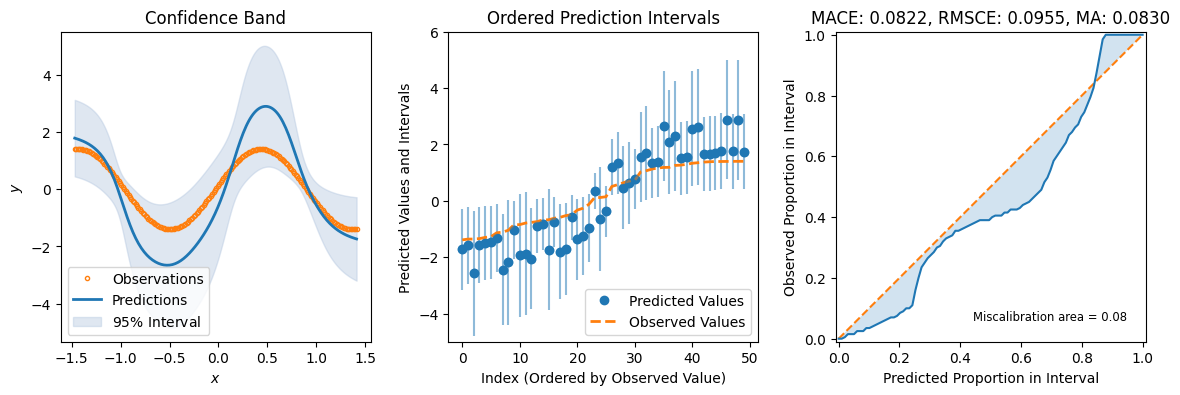

In [34]:
fig = plot_calibration_uq_toolbox(
    preds["pred"].cpu().numpy(),
    preds["pred_uct"].cpu().numpy(),
    y_test.cpu().numpy(),
    X_test.cpu().numpy(),
)

## Additional Resources

Links to othere related literature that might be interesting.